# Import de la db

In [158]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score
from category_encoders import TargetEncoder
import matplotlib.pyplot as plt

In [159]:
df = pd.read_csv("SBAnational.csv")

/tmp/ipykernel_6729/3536806131.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("SBAnational.csv")


In [160]:
df.head(1)

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,...,N,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"


## Gerer les targets null

In [161]:
df["MIS_Status"].isnull().sum()

np.int64(1997)

In [162]:
df_without_null = df[df["MIS_Status"].notnull()]

In [163]:
df['ChgOffDate_null'] = df['ChgOffDate'].isnull().astype(int)  # 1 si null, 0 sinon
df['MIS_Status_numeric'] = df['MIS_Status'].map({'P I F': 1, 'CHGOFF': 0})  # 1 = remboursé, 0 = défaut
correlation = df[['ChgOffDate_null', 'MIS_Status_numeric']].corr()
print(correlation)


                    ChgOffDate_null  MIS_Status_numeric
ChgOffDate_null            1.000000            0.981252
MIS_Status_numeric         0.981252            1.000000


On a une énorme corrélation. On va remplacer les targets null en prenant en compte ce ChgOffDate

In [164]:
df['MIS_Status'] = df.apply(
    lambda row: 'P I F' if pd.isna(row['ChgOffDate']) else 'CHGOFF' 
    if pd.isna(row['MIS_Status']) else row['MIS_Status'],
    axis=1
)

## Format des colonnes

Suppression des colonnes de targets leakings et d'autres colonnes inutile :

In [165]:
df = df.drop(["LoanNr_ChkDgt", "Name", "ChgOffDate", "DisbursementDate", "BalanceGross", "ChgOffPrinGr", "SBA_Appv"], axis=1)
df_without_null = df_without_null.drop(["LoanNr_ChkDgt", "Name", "ChgOffDate", "DisbursementDate", "BalanceGross", "ChgOffPrinGr", "SBA_Appv"], axis=1)

In [166]:
df.dtypes

City                   object
State                  object
Zip                     int64
Bank                   object
BankState              object
NAICS                   int64
ApprovalDate           object
ApprovalFY             object
Term                    int64
NoEmp                   int64
NewExist              float64
CreateJob               int64
RetainedJob             int64
FranchiseCode           int64
UrbanRural              int64
RevLineCr              object
LowDoc                 object
DisbursementGross      object
MIS_Status             object
GrAppv                 object
ChgOffDate_null         int64
MIS_Status_numeric    float64
dtype: object

In [167]:
print(df.map(lambda x: isinstance(x, str)).sum())

City                  899134
State                 899150
Zip                        0
Bank                  897605
BankState             897598
NAICS                      0
ApprovalDate          899164
ApprovalFY            131072
Term                       0
NoEmp                      0
NewExist                   0
CreateJob                  0
RetainedJob                0
FranchiseCode              0
UrbanRural                 0
RevLineCr             894636
LowDoc                896582
DisbursementGross     899164
MIS_Status            899164
GrAppv                899164
ChgOffDate_null            0
MIS_Status_numeric         0
dtype: int64


In [168]:
for col in df.select_dtypes(include=['object']).columns:
    print(f"🔍 {col}: {df[col].unique()}")

🔍 City: ['EVANSVILLE' 'NEW PARIS' 'BLOOMINGTON' ... 'MURFRECSBORO' 'E WENALCHEE'
 'SO. OZONE PARK']
🔍 State: ['IN' 'OK' 'FL' 'CT' 'NJ' 'NC' 'IL' 'RI' 'TX' 'VA' 'TN' 'AR' 'MN' 'MO'
 'MA' 'CA' 'SC' 'LA' 'IA' 'OH' 'KY' 'MS' 'NY' 'MD' 'PA' 'OR' 'ME' 'KS'
 'MI' 'AK' 'WA' 'CO' 'MT' 'WY' 'UT' 'NH' 'WV' 'ID' 'AZ' 'NV' 'WI' 'NM'
 'GA' 'ND' 'VT' 'AL' 'NE' 'SD' 'HI' 'DE' 'DC' nan]
🔍 Bank: ['FIFTH THIRD BANK' '1ST SOURCE BANK' 'GRANT COUNTY STATE BANK' ...
 'FIRST ILLINOIS BANK' 'COLORADO COMMUNITY FIRST STATE' 'DEPCO']
🔍 BankState: ['OH' 'IN' 'OK' 'FL' 'DE' 'SD' 'AL' 'CT' 'GA' 'OR' 'MN' 'RI' 'NC' 'TX'
 'MD' 'NY' 'TN' 'SC' 'MS' 'MA' 'LA' 'IA' 'VA' 'CA' 'IL' 'KY' 'PA' 'MO'
 'WA' 'MI' 'UT' 'KS' 'WV' 'WI' 'AZ' 'NJ' 'CO' 'ME' 'NH' 'AR' 'ND' 'MT'
 'ID' nan 'WY' 'NM' 'DC' 'NV' 'NE' 'PR' 'HI' 'VT' 'AK' 'GU' 'AN' 'EN' 'VI']
🔍 ApprovalDate: ['28-Feb-97' '2-Jun-80' '7-Feb-06' ... '24-Feb-97' '25-Feb-97' '27-Feb-97']
🔍 ApprovalFY: [1997 1980 2006 1998 1999 2000 2001 1972 2003 2004 1978 1979 1981 2005
 1962 1

In [169]:
df["Bank"].unique()

array(['FIFTH THIRD BANK', '1ST SOURCE BANK', 'GRANT COUNTY STATE BANK',
       ..., 'FIRST ILLINOIS BANK', 'COLORADO COMMUNITY FIRST STATE',
       'DEPCO'], shape=(5803,), dtype=object)

Trop de valeur on ne prend pas cette colonne...

In [170]:
df["NAICS"].unique()

array([451120, 722410, 621210, ..., 315280, 922140, 221121], shape=(1312,))

On ne garde que les deux premiers chiffres

In [171]:
df["NAICS"] = df["NAICS"].astype(str).str[:2]
df["NAICS"].unique()

array(['45', '72', '62', '0', '33', '81', '23', '44', '42', '61', '53',
       '54', '31', '51', '71', '52', '21', '32', '56', '48', '11', '92',
       '22', '49', '55'], dtype=object)

In [172]:
df["NewExist"].value_counts()

NewExist
1.0    644869
2.0    253125
0.0      1034
Name: count, dtype: int64

In [173]:
df["FranchiseCode"].unique(
)

array([    1,     0, 15100, ...,  2899, 18701, 15930], shape=(2768,))

In [174]:
df["UrbanRural"].value_counts()

UrbanRural
1    470654
0    323167
2    105343
Name: count, dtype: int64

In [175]:
df["RevLineCr"].value_counts()

RevLineCr
N    420288
0    257602
Y    201397
T     15284
1        23
R        14
`        11
2         6
C         2
,         1
3         1
7         1
A         1
5         1
.         1
4         1
-         1
Q         1
Name: count, dtype: int64

In [176]:
df["LowDoc"].value_counts()

LowDoc
N    782822
Y    110335
0      1491
C       758
S       603
A       497
R        75
1         1
Name: count, dtype: int64

### Champs dates

In [177]:
df['ApprovalDate'] = pd.to_datetime(df['ApprovalDate'], format='%d-%b-%y')

df['ApprovalDate'] = df['ApprovalDate'].apply(
    lambda x: x - pd.DateOffset(years=100) if x.year > 2014 else x)

In [178]:
df['ApprovalFY'] = pd.to_numeric(df['ApprovalFY'], errors='coerce')
df['ApprovalFY'] = df['ApprovalFY'].astype('Int64')  # Int64 permet d'avoir des NaN

### Champs Moulaga

In [179]:
cols_to_convert = ['GrAppv', 'DisbursementGross']

for col in cols_to_convert:
    df[col] = df[col].astype(str)  # S'assure que c'est une string
    df[col] = df[col].str.replace('[\$,]', '', regex=True)  # Retire $ et ,
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Convertit en float

In [180]:
print(df[cols_to_convert].dtypes) 

GrAppv               float64
DisbursementGross    float64
dtype: object


In [181]:
count_diff = (df['DisbursementGross'] != df['GrAppv']).sum()
count_diff

np.int64(210481)

In [182]:
df['MIS_Status'] = df['MIS_Status'].map({'P I F': 1, 'CHGOFF': 0})

In [183]:
df["UrbanRural"].unique()

array([0, 1, 2])

# Preparation des données :

In [184]:
df['State'] = df['State'].fillna(df['BankState'])
recession_start = pd.Timestamp('2007-12-01')
recession_end = pd.Timestamp('2009-06-30')
df['Recession'] = ((df['ApprovalDate'] >= recession_start) & (df['ApprovalDate'] <= recession_end)).astype(int)
df['NewExist'] = df['NewExist'].map({2: 1, 1: 0, 0: np.nan})
df['UrbanRural'] = df['UrbanRural'].map({2: 1, 1: 0, 0: np.nan})
df['HasFranchise'] = (df['FranchiseCode'] >= 100).astype(int)
df['RevLineCr'] = df['RevLineCr'].apply(lambda x: x if x in ['Y', 'N'] else np.nan)  # Garde seulement Y et N, sinon NaN
df['RevLineCr'] = df['RevLineCr'].map({'Y': 1, 'N': 0})  # Convertit Y -> 1 et N -> 0
df['LowDoc'] = df['LowDoc'].apply(lambda x: x if x in ['Y', 'N'] else np.nan)  # Garde seulement Y et N, sinon NaN
df['LowDoc'] = df['LowDoc'].map({'Y': 1, 'N': 0})  # Convertit Y -> 1 et N -> 0
df['NAICS'] = df['NAICS'].replace('0', np.nan)

In [185]:
features_of_interest = [
    "State",
    "NAICS",
    "Term",
    "NoEmp",
    "NewExist",
    'CreateJob', 
    'RetainedJob',
    'UrbanRural',
    'RevLineCr', 
    'LowDoc',
    'GrAppv',
    'Recession',
    'HasFranchise'
    ]




data = df

target_name = "MIS_Status"
X, y = (
    data[features_of_interest],
    data[target_name]
)

In [186]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 899164 entries, 0 to 899163
Series name: MIS_Status
Non-Null Count   Dtype
--------------   -----
899164 non-null  int64
dtypes: int64(1)
memory usage: 6.9 MB


<Axes: >

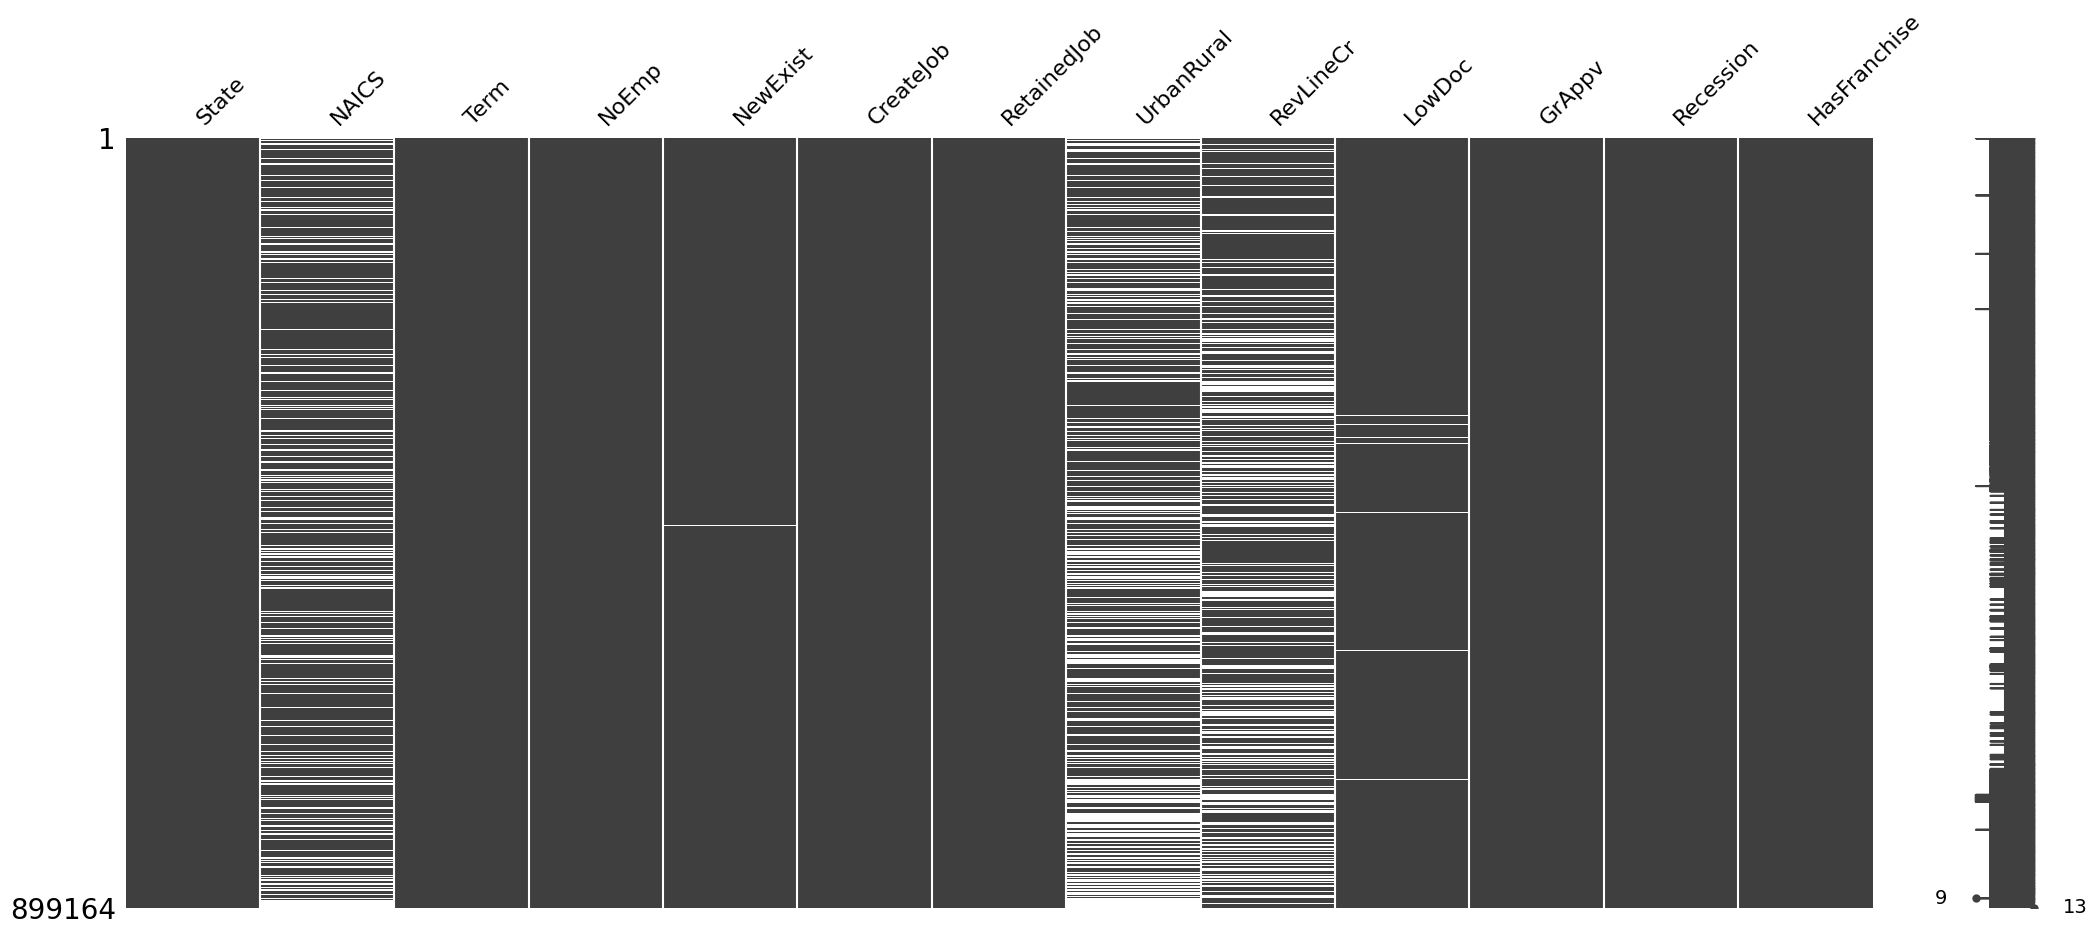

In [187]:
import missingno as msno
msno.matrix(X)

In [188]:
print(X.isnull().sum())

State                1
NAICS           201948
Term                 0
NoEmp                0
NewExist          1170
CreateJob            0
RetainedJob          0
UrbanRural      323167
RevLineCr       277479
LowDoc            6007
GrAppv               0
Recession            0
HasFranchise         0
dtype: int64


In [189]:
pd.crosstab(df["State"], df["BankState"])

BankState,AK,AL,AN,AR,AZ,CA,CO,CT,DC,DE,...,TN,TX,UT,VA,VI,VT,WA,WI,WV,WY
State,,,,,,,,,,,,,,,,,,,,,
AK,1414,0,0,3,0,144,3,3,5,0,...,0,13,2,50,0,1,89,0,0,0
AL,1,5395,0,9,1,629,4,5,4,32,...,98,91,14,270,0,0,0,0,0,0
AR,0,97,0,4772,2,208,1,4,13,1,...,37,112,20,194,0,0,0,0,0,0
AZ,3,441,0,0,3709,1918,185,81,88,2,...,9,556,168,422,0,0,1,61,0,0
CA,2,43,0,2,58,76478,1997,127,1305,9,...,25,4505,511,3264,0,0,103,7,0,1
CO,1,311,0,5,19,1979,7621,17,95,3,...,7,494,369,684,0,0,1,8,0,32
CT,0,3,0,0,0,407,1,5486,9,544,...,5,60,6,320,0,4,0,1,0,0
DC,0,0,0,0,0,481,1,10,192,80,...,0,15,2,147,0,0,0,0,0,0
DE,0,1,1,1,0,126,7,2,12,990,...,1,14,2,51,0,0,0,0,2,0


In [190]:
print(y.isnull().sum())

0


In [191]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.1, random_state=42, stratify=y)

## Preprocessing

In [192]:
# Pas encore fait : UrbanRural

    
# class FillStateTransformer(BaseEstimator, TransformerMixin):
#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         X = X.copy()
#         X['State'] = X['State'].fillna(X['BankState'])
#         return X

# class DropColumnsTransformer(BaseEstimator, TransformerMixin):
#     def __init__(self, columns):
#         self.columns = columns  # Liste des colonnes à supprimer

#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         X = X.copy()
#         return X.drop(columns=self.columns, errors='ignore') 

class CustomMeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, col):
        self.col = col
        self.encoder = TargetEncoder(cols=[col])
    
    def fit(self, X, y):
        self.encoder.fit(X[[self.col]], y)
        return self

    def transform(self, X):
        X = X.copy()
        X[self.col] = self.encoder.transform(X[[self.col]])
        return X
    
# class NAICSNullTransformer(BaseEstimator, TransformerMixin):
#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         X = X.copy()
#         X['NAICS'] = X['NAICS'].replace('0', np.nan)  # Remplace "0" par NaN
#         return X
    
# class RecessionTransformer(BaseEstimator, TransformerMixin):
#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         X = X.copy()
#         recession_start = pd.Timestamp('2007-12-01')
#         recession_end = pd.Timestamp('2009-06-30')
#         X['Recession'] = ((X['ApprovalDate'] >= recession_start) & (X['ApprovalDate'] <= recession_end)).astype(int)
#         return X

# class NewExistTransformer(BaseEstimator, TransformerMixin):
#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         X = X.copy()
#         X['NewExist'] = X['NewExist'].map({2: 1, 1: 0, 0: np.nan})  # Transformation des valeurs
#         return X

# class FranchiseTransformer(BaseEstimator, TransformerMixin):
#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         X = X.copy()
#         X['HasFranchise'] = (X['FranchiseCode'] >= 100).astype(int)  # 1 si au moins 3 chiffres, 0 sinon
#         return X


# class CustomBinaryColumnTransformer(BaseEstimator, TransformerMixin):
#     def __init__(self, columns):
#         self.columns = columns

#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         X = X.copy()
#         for col in self.columns:
#             X[col] = X[col].apply(lambda x: x if x in ['Y', 'N'] else np.nan)  # Garde seulement Y et N, sinon NaN
#             X[col] = X[col].map({'Y': 1, 'N': 0})  # Convertit Y -> 1 et N -> 0
#         return X

In [193]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import TargetEncoder

# preprocessor = Pipeline([
#     ('mean_target_encoder', CustomMeanTargetEncoder(col='State')),
#     ('mean_target_encoder_naisc', CustomMeanTargetEncoder(col='NAICS')),
# ])

other_features = [
    "Term",
    "NoEmp",
    "NewExist",
    'CreateJob', 
    'RetainedJob',
    'UrbanRural',
    'RevLineCr', 
    'LowDoc',
    'GrAppv',
    'Recession',
    'HasFranchise'
    ]

preprocessor = ColumnTransformer(
    [
        (
            "mean_target_encoder",
            TargetEncoder(target_type="continuous"),
            ['State','NAICS'],
        ),
        ("other", "passthrough", other_features),
    ],
)

In [194]:
X_train.columns

Index(['State', 'NAICS', 'Term', 'NoEmp', 'NewExist', 'CreateJob',
       'RetainedJob', 'UrbanRural', 'RevLineCr', 'LowDoc', 'GrAppv',
       'Recession', 'HasFranchise'],
      dtype='object')

In [195]:
preprocessor.fit(X_train,y_train)

ColumnTransformer(transformers=[('mean_target_encoder',
                                 TargetEncoder(target_type='continuous'),
                                 ['State', 'NAICS']),
                                ('other', 'passthrough',
                                 ['Term', 'NoEmp', 'NewExist', 'CreateJob',
                                  'RetainedJob', 'UrbanRural', 'RevLineCr',
                                  'LowDoc', 'GrAppv', 'Recession',
                                  'HasFranchise'])])

In [196]:
X_transformed = preprocessor.transform(X_train)

In [197]:
X_transformed

array([[8.60332993e-01, 7.79782428e-01, 2.40000000e+02, ...,
        3.84000000e+05, 0.00000000e+00, 1.00000000e+00],
       [8.46444855e-01, 7.65875231e-01, 4.40000000e+01, ...,
        1.00000000e+04, 0.00000000e+00, 0.00000000e+00],
       [8.70822565e-01, 7.68096064e-01, 8.40000000e+01, ...,
        7.50000000e+04, 0.00000000e+00, 0.00000000e+00],
       ...,
       [8.44574601e-01, 7.76729940e-01, 3.60000000e+01, ...,
        1.25000000e+05, 0.00000000e+00, 0.00000000e+00],
       [8.22155367e-01, 8.03310163e-01, 8.40000000e+01, ...,
        9.50000000e+04, 0.00000000e+00, 0.00000000e+00],
       [8.11134648e-01, 9.16532046e-01, 6.00000000e+01, ...,
        8.00000000e+04, 0.00000000e+00, 0.00000000e+00]],
      shape=(809247, 13))

In [198]:
import xgboost as xgb

xgboost_model = Pipeline([
    ('preprocessor', preprocessor),  
    ('xgboost', xgb.XGBClassifier(eval_metric='auc'))
])

In [199]:
xgboost_model.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('mean_target_encoder',
                                                  TargetEncoder(target_type='continuous'),
                                                  ['State', 'NAICS']),
                                                 ('other', 'passthrough',
                                                  ['Term', 'NoEmp', 'NewExist',
                                                   'CreateJob', 'RetainedJob',
                                                   'UrbanRural', 'RevLineCr',
                                                   'LowDoc', 'GrAppv',
                                                   'Recession',
                                                   'HasFranchise'])])),
                ('xgboost',
                 XGBClassifier(base_score=None, booster=None...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [200]:
y_pred = xgboost_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

In [201]:
from sklearn.metrics import roc_auc_score, f1_score


y_pred = xgboost_model.predict(X_test)
y_pred_prob = xgboost_model.predict_proba(X_test)[:, 1]  

f1 = f1_score(y_test, y_pred)

auc = roc_auc_score(y_test, y_pred_prob)

print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")


F1 Score: 0.9624
AUC: 0.9669


In [202]:
xgboost_model.score(X_test,y_test)

0.9374089438037301

In [ ]:
param_grid = {
    "xgboost__eta": np.linspace(0.1,0.9,9),
}

grid_search = GridSearchCV(
    xgboost_model,
    param_grid,
    cv=5,
    scoring="roc_auc",
)
grid_search.fit(X_train, y_train)

grid_search.best_params_

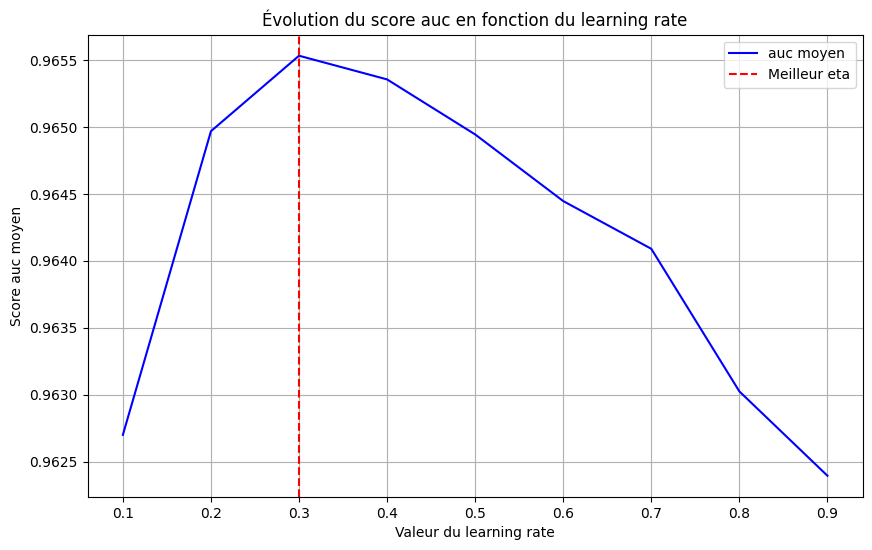

In [ ]:
results = grid_search.cv_results_
alphas = results["param_xgboost__eta"].data
mean_scores = results["mean_test_score"]  


plt.figure(figsize=(10, 6))
plt.plot(alphas, mean_scores, label="auc moyen", color="blue")

# Ajouter des annotations
plt.axvline(grid_search.best_params_["xgboost__eta"], color="red", linestyle="--", label="Meilleur eta")
plt.xlabel("Valeur du learning rate")
plt.ylabel("Score auc moyen")
plt.title("Évolution du score auc en fonction du learning rate")
plt.legend()
plt.grid(True)
plt.show()

In [127]:
xgboost_model.set_params(xgboost__eta = 0.4)
xgboost_model.fit(X_train, y_train)
y_pred = xgboost_model.predict(X_test)
y_pred_prob = xgboost_model.predict_proba(X_test)[:, 1]  

f1 = f1_score(y_test, y_pred)

auc = roc_auc_score(y_test, y_pred_prob)

print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

F1 Score: 0.9620
AUC: 0.9668
